# Computer Vision Homework 7: Face Recognition using Eigenfaces

### Algorithm Summary:
1. **Training Phase**: For each person (1-5), learn a PCA subspace from their training images
2. **Testing Phase**: Project test images onto each person's subspace and classify based on minimum reconstruction error
3. **Classification**: Choose the person whose subspace gives the smallest reconstruction error

### Data Structure:
- Training images: `./Faces/Train/<person_id>_<illumination_id>.jpg`
- Test images: `./Faces/Test/<person_id>_<illumination_id>.jpg`
- 5 people total, multiple illumination conditions per person

## 1. Import Required Libraries

Import all necessary libraries for image processing, PCA computation, and visualization.

In [16]:
%pip install numpy matplotlib scikit-learn opencv-python seaborn

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

NumPy version: 2.4.1
OpenCV version: 4.13.0


## 2. Configuration and Helper Functions

In [18]:

CONFIG = {
    'train_path': './Faces/Train/',
    'test_path': './Faces/Test/',
    'image_size': (64, 64),
    'num_people': 5,
    'variance_threshold': 0.95
}

def extract_person_id(filename):
    """Extract person ID from filename (format: personID_illuminationID.jpg)"""
    return int(filename.split('_')[0])

def load_and_preprocess_image(filepath, target_size=(64, 64)):
    """Load image, convert to grayscale, resize, and normalize"""
    try:
        # Read image
        img = cv2.imread(filepath)
        if img is None:
            raise ValueError(f"Could not load image: {filepath}")
        
        # Convert to grayscale
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize to target size
        img = cv2.resize(img, target_size)
        
        # Normalize to [0, 1]
        img = img.astype(np.float64) / 255.0
        
        return img
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def flatten_image(img):
    """Flatten 2D image to 1D vector"""
    return img.flatten()

def reshape_to_image(vector, target_size=(64, 64)):
    """Reshape 1D vector back to 2D image"""
    return vector.reshape(target_size)

print("Configuration and helper functions defined successfully!")
print(f"Target image size: {CONFIG['image_size']}")
print(f"Number of people: {CONFIG['num_people']}")
print(f"Variance threshold: {CONFIG['variance_threshold']}")

Configuration and helper functions defined successfully!
Target image size: (64, 64)
Number of people: 5
Variance threshold: 0.95


## 3. Load and Preprocess Training Data

In [19]:
def load_training_data(train_path, target_size=(64, 64)):
    """Load and organize training data by person"""
    # Dictionary to store images for each person
    person_images = defaultdict(list)
    person_vectors = defaultdict(list)
    
    # Get all jpg files in training directory
    image_files = glob.glob(os.path.join(train_path, '*.jpg'))
    
    print(f"Found {len(image_files)} training images")
    
    for filepath in image_files:
        filename = os.path.basename(filepath)
        person_id = extract_person_id(filename)
        
        # Load and preprocess image
        img = load_and_preprocess_image(filepath, target_size)
        
        if img is not None:
            person_images[person_id].append(img)
            person_vectors[person_id].append(flatten_image(img))
    
    # Convert lists to numpy arrays
    for person_id in person_vectors:
        person_vectors[person_id] = np.array(person_vectors[person_id])
        person_images[person_id] = np.array(person_images[person_id])
    
    return person_images, person_vectors

# Load training data
print("Loading training data...")
train_images, train_vectors = load_training_data(CONFIG['train_path'], CONFIG['image_size'])

# Print statistics
print("\nTraining Data Statistics:")
for person_id in sorted(train_vectors.keys()):
    num_images = len(train_vectors[person_id])
    print(f"Person {person_id}: {num_images} images")

total_images = sum(len(vectors) for vectors in train_vectors.values())
print(f"\nTotal training images: {total_images}")
print(f"Image dimensions: {CONFIG['image_size']}")
print(f"Feature vector size: {CONFIG['image_size'][0] * CONFIG['image_size'][1]}")

Loading training data...
Found 141 training images

Training Data Statistics:
Person 1: 28 images
Person 2: 29 images
Person 3: 27 images
Person 4: 29 images
Person 5: 28 images

Total training images: 141
Image dimensions: (64, 64)
Feature vector size: 4096


## 4. Visualize Sample Training Images

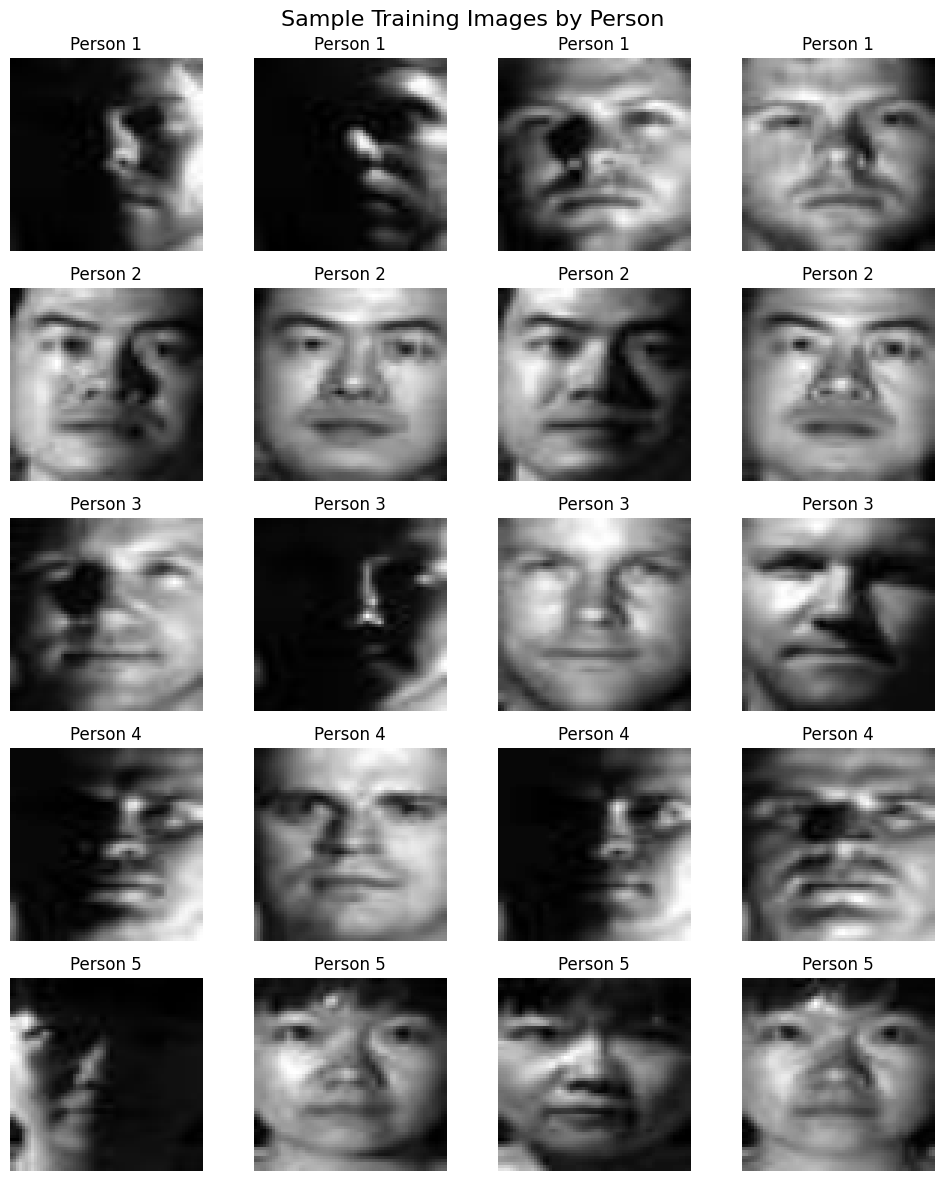

In [20]:
# Visualize sample training images
def plot_sample_images(person_images, num_samples=3):
    """Plot sample images for each person"""
    num_people = len(person_images)
    
    fig, axes = plt.subplots(num_people, num_samples, figsize=(10, 12))
    fig.suptitle('Sample Training Images by Person', fontsize=16)
    
    for i, person_id in enumerate(sorted(person_images.keys())):
        images = person_images[person_id]
        for j in range(min(num_samples, len(images))):
            ax = axes[i, j] if num_people > 1 else axes[j]
            ax.imshow(images[j], cmap='gray')
            ax.set_title(f'Person {person_id}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(train_images, num_samples=4)

## 5. Implement Eigenfaces using PCA

For each person, compute their eigenfaces (principal components) from their training images. This creates a personalized subspace for each individual.

In [21]:
class EigenFaceClassifier:
    """Eigenfaces-based face recognition classifier"""
    
    def __init__(self, variance_threshold=0.95):
        self.variance_threshold = variance_threshold
        self.person_models = {}  # Dictionary to store PCA models for each person
        self.person_means = {}   # Mean faces for each person
        
    def train_person_model(self, person_id, person_vectors):
        """Train PCA model for a specific person"""
        print(f"Training model for Person {person_id}...")
        
        # Convert to numpy array if needed
        X = np.array(person_vectors)
        
        # Compute mean face for this person
        mean_face = np.mean(X, axis=0)
        self.person_means[person_id] = mean_face
        
        # Center the data (subtract mean)
        X_centered = X - mean_face
        
        # Apply PCA
        pca = PCA()
        pca.fit(X_centered)
        
        # Determine number of components based on variance threshold
        cumsum_var = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumsum_var >= self.variance_threshold) + 1
        
        # Keep only the required number of components
        pca_final = PCA(n_components=n_components)
        pca_final.fit(X_centered)
        
        # Store the model
        self.person_models[person_id] = {
            'pca': pca_final,
            'mean_face': mean_face,
            'n_components': n_components,
            'explained_variance_ratio': pca_final.explained_variance_ratio_.sum()
        }
        
        print(f" Mean face computed: {mean_face.shape}")
        print(f" Components kept: {n_components} (explaining {pca_final.explained_variance_ratio_.sum():.3f} of variance)")
        
        return pca_final
    
    def train(self, train_vectors):
        """Train eigenfaces models for all people"""
        print("=== Training Eigenfaces Models ===")
        
        for person_id in sorted(train_vectors.keys()):
            self.train_person_model(person_id, train_vectors[person_id])
        
        print("\nTraining completed successfully!")
        return self
    
    def predict_single(self, test_vector):
        """Predict the person ID for a single test image"""
        reconstruction_errors = {}
        
        for person_id, model in self.person_models.items():
            pca = model['pca']
            mean_face = model['mean_face']
            
            # Center the test vector
            test_centered = test_vector - mean_face
            
            # Project onto the person's eigenface subspace
            projection = pca.transform(test_centered.reshape(1, -1))
            
            # Reconstruct the image
            reconstruction = pca.inverse_transform(projection)
            reconstruction = reconstruction.flatten() + mean_face
            
            # Calculate reconstruction error (Euclidean distance)
            error = np.linalg.norm(test_vector - reconstruction)
            reconstruction_errors[person_id] = error
        
        # Return the person with minimum reconstruction error
        predicted_person = min(reconstruction_errors, key=reconstruction_errors.get)
        return predicted_person, reconstruction_errors
    
    def predict(self, test_vectors):
        """Predict person IDs for multiple test images"""
        predictions = []
        all_errors = []
        
        for test_vector in test_vectors:
            pred, errors = self.predict_single(test_vector)
            predictions.append(pred)
            all_errors.append(errors)
        
        return np.array(predictions), all_errors

# Initialize and train the classifier
print("Initializing EigenFaces Classifier...")
classifier = EigenFaceClassifier(variance_threshold=CONFIG['variance_threshold'])

# Train the classifier
classifier.train(train_vectors)

Initializing EigenFaces Classifier...
=== Training Eigenfaces Models ===
Training model for Person 1...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.966 of variance)
Training model for Person 2...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.968 of variance)
Training model for Person 3...
 Mean face computed: (4096,)
 Components kept: 4 (explaining 0.965 of variance)
Training model for Person 4...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.973 of variance)
Training model for Person 5...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.955 of variance)

Training completed successfully!


## 6. Visualize Eigenfaces

Display the eigenfaces (principal components) computed for each person. These represent the main variations in facial features for each individual.

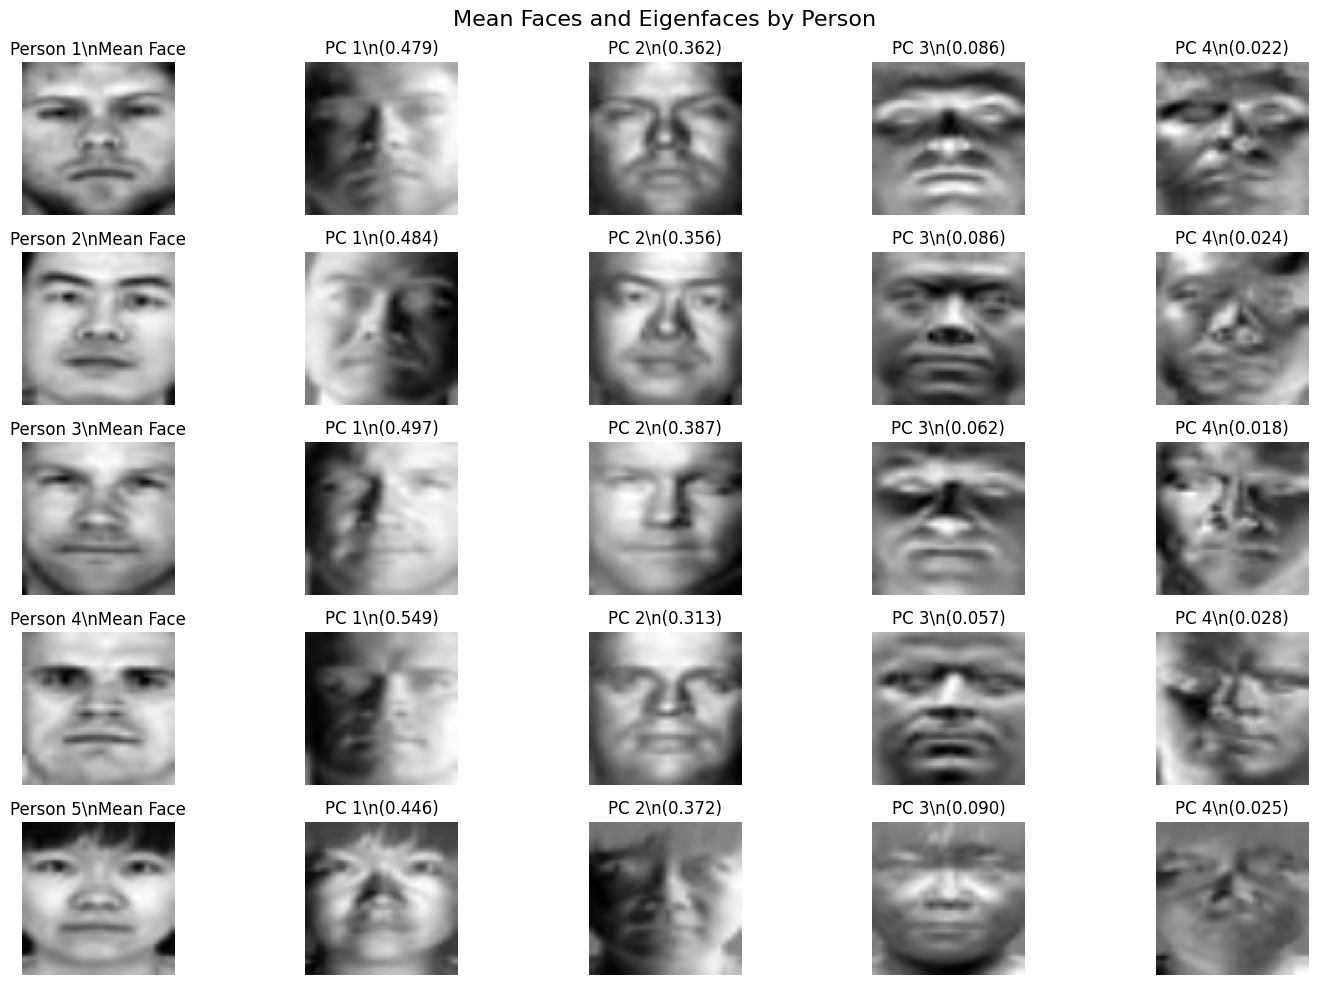

\n=== Model Summary ===
Person 1:
  - Components: 5
  - Variance explained: 0.966
  - Mean face range: [0.081, 0.486]
Person 2:
  - Components: 5
  - Variance explained: 0.968
  - Mean face range: [0.027, 0.483]
Person 3:
  - Components: 4
  - Variance explained: 0.965
  - Mean face range: [0.082, 0.556]
Person 4:
  - Components: 5
  - Variance explained: 0.973
  - Mean face range: [0.060, 0.351]
Person 5:
  - Components: 5
  - Variance explained: 0.955
  - Mean face range: [0.010, 0.482]


In [22]:
def visualize_eigenfaces(classifier, target_size=(64, 64), max_components=5):
    """Visualize eigenfaces for each person"""
    
    num_people = len(classifier.person_models)
    
    fig, axes = plt.subplots(num_people, max_components + 1, figsize=(15, 10))
    fig.suptitle('Mean Faces and Eigenfaces by Person', fontsize=16)
    
    for i, person_id in enumerate(sorted(classifier.person_models.keys())):
        model = classifier.person_models[person_id]
        pca = model['pca']
        mean_face = model['mean_face']
        
        # Plot mean face
        ax = axes[i, 0] if num_people > 1 else axes[0]
        mean_face_img = reshape_to_image(mean_face, target_size)
        ax.imshow(mean_face_img, cmap='gray')
        ax.set_title(f'Person {person_id}\\nMean Face')
        ax.axis('off')
        
        # Plot eigenfaces
        components = pca.components_
        for j in range(min(max_components, len(components))):
            ax = axes[i, j + 1] if num_people > 1 else axes[j + 1]
            
            # Normalize eigenface for visualization
            eigenface = components[j]
            eigenface = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
            eigenface_img = reshape_to_image(eigenface, target_size)
            
            ax.imshow(eigenface_img, cmap='gray')
            var_explained = pca.explained_variance_ratio_[j]
            ax.set_title(f'PC {j+1}\\n({var_explained:.3f})')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize eigenfaces
visualize_eigenfaces(classifier, CONFIG['image_size'], max_components=4)

# Print summary statistics
print("\\n=== Model Summary ===")
for person_id in sorted(classifier.person_models.keys()):
    model = classifier.person_models[person_id]
    print(f"Person {person_id}:")
    print(f"  - Components: {model['n_components']}")
    print(f"  - Variance explained: {model['explained_variance_ratio']:.3f}")
    print(f"  - Mean face range: [{model['mean_face'].min():.3f}, {model['mean_face'].max():.3f}]")

## 7. Load and Preprocess Test Data

Load test images and prepare them for classification.

In [23]:
def load_test_data(test_path, target_size=(64, 64)):
    """Load and preprocess test data"""
    test_vectors = []
    test_labels = []
    test_filenames = []
    
    image_files = glob.glob(os.path.join(test_path, '*.jpg'))
    image_files.sort() 
    
    print(f"Found {len(image_files)} test images")
    
    for filepath in image_files:
        filename = os.path.basename(filepath)
        person_id = extract_person_id(filename)
        
        # Load and preprocess image
        img = load_and_preprocess_image(filepath, target_size)
        
        if img is not None:
            test_vectors.append(flatten_image(img))
            test_labels.append(person_id)
            test_filenames.append(filename)
    
    return np.array(test_vectors), np.array(test_labels), test_filenames

# Load test data
print("Loading test data...")
test_vectors, test_labels, test_filenames = load_test_data(CONFIG['test_path'], CONFIG['image_size'])

print(f"\nTest Data Statistics:")
print(f"Total test images: {len(test_vectors)}")
for person_id in range(1, CONFIG['num_people'] + 1):
    count = np.sum(test_labels == person_id)
    print(f"Person {person_id}: {count} images")

print(f"\nTest vector shape: {test_vectors.shape}")
print(f"Test labels shape: {test_labels.shape}")

Loading test data...
Found 145 test images

Test Data Statistics:
Total test images: 145
Person 1: 30 images
Person 2: 28 images
Person 3: 28 images
Person 4: 30 images
Person 5: 29 images

Test vector shape: (145, 4096)
Test labels shape: (145,)


## 8. Classify Test Images

Use the trained eigenfaces model to classify test images and compute the classification rate.

In [24]:
# Perform classification on test images
print("=== Classifying Test Images ===")
print("Predicting person IDs for test images...")

# Make predictions
predictions, reconstruction_errors = classifier.predict(test_vectors)

# Calculate accuracy
accuracy = np.mean(predictions == test_labels)
classification_rate = accuracy * 100

print(f"\\n=== RESULTS ===")
print(f"Classification Rate: {classification_rate:.2f}%")
print(f"Correctly classified: {np.sum(predictions == test_labels)} out of {len(test_labels)}")

# Detailed results per person
print(f"\\n=== Per-Person Results ===")
for person_id in range(1, CONFIG['num_people'] + 1):
    person_mask = test_labels == person_id
    if np.any(person_mask):
        person_predictions = predictions[person_mask]
        person_accuracy = np.mean(person_predictions == person_id) * 100
        person_count = np.sum(person_mask)
        correct_count = np.sum(person_predictions == person_id)
        print(f"Person {person_id}: {correct_count}/{person_count} correct ({person_accuracy:.1f}%)")

print(f"\\n=== Sample Predictions ===")
for i in range(min(10, len(predictions))):
    actual = test_labels[i]
    predicted = predictions[i]
    filename = test_filenames[i]
    status = "✓" if actual == predicted else "✗"
    print(f"{status} {filename}: Actual={actual}, Predicted={predicted}")
    
    errors = reconstruction_errors[i]
    print(f"  Reconstruction errors: {', '.join([f'P{pid}:{err:.3f}' for pid, err in errors.items()])}")
    print()

=== Classifying Test Images ===
Predicting person IDs for test images...
\n=== RESULTS ===
Classification Rate: 98.62%
Correctly classified: 143 out of 145
\n=== Per-Person Results ===
Person 1: 29/30 correct (96.7%)
Person 2: 28/28 correct (100.0%)
Person 3: 27/28 correct (96.4%)
Person 4: 30/30 correct (100.0%)
Person 5: 29/29 correct (100.0%)
\n=== Sample Predictions ===
✓ 1_1.jpg: Actual=1, Predicted=1
  Reconstruction errors: P1:1.388, P2:7.190, P3:6.035, P4:6.160, P5:12.263

✓ 1_10.jpg: Actual=1, Predicted=1
  Reconstruction errors: P1:1.518, P2:6.663, P3:6.207, P4:6.523, P5:10.439

✓ 1_12.jpg: Actual=1, Predicted=1
  Reconstruction errors: P1:1.757, P2:7.923, P3:6.512, P4:6.357, P5:13.220

✓ 1_14.jpg: Actual=1, Predicted=1
  Reconstruction errors: P1:1.788, P2:5.394, P3:6.702, P4:5.789, P5:7.270

✓ 1_16.jpg: Actual=1, Predicted=1
  Reconstruction errors: P1:2.503, P2:9.159, P3:7.629, P4:6.908, P5:14.311

✓ 1_18.jpg: Actual=1, Predicted=1
  Reconstruction errors: P1:6.136, P2:9.7

## 9. Visualize Results and Analysis

Create confusion matrix and show examples of correct and incorrect predictions.

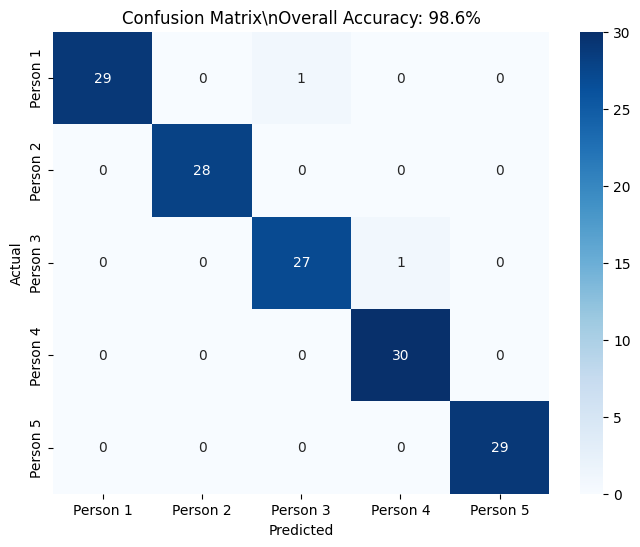

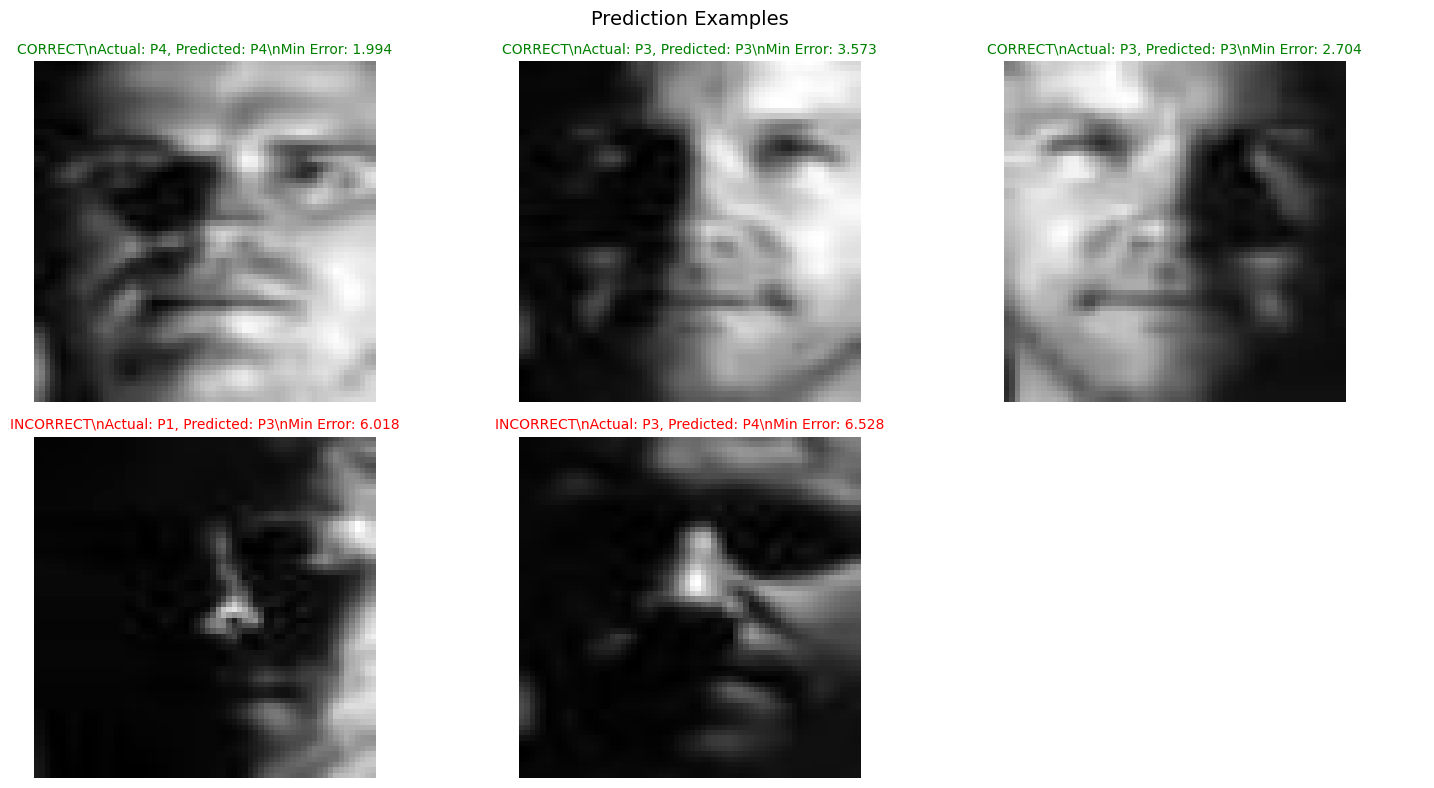

In [25]:
# Create confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Person {i}' for i in range(1, 6)],
            yticklabels=[f'Person {i}' for i in range(1, 6)])
plt.title(f'Confusion Matrix\\nOverall Accuracy: {classification_rate:.1f}%')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

def show_prediction_examples(test_path, test_filenames, test_labels, predictions, 
                           reconstruction_errors, num_examples=6):
    """Show example predictions with images and reconstruction errors"""
    
    fig, axes = plt.subplots(2, num_examples//2, figsize=(15, 8))
    axes = axes.flatten()
    
    # Find some correct and incorrect predictions
    correct_indices = np.where(predictions == test_labels)[0]
    incorrect_indices = np.where(predictions != test_labels)[0]
    
    # Select examples (mix of correct and incorrect)
    example_indices = []
    if len(correct_indices) > 0:
        example_indices.extend(np.random.choice(correct_indices, 
                                              min(num_examples//2, len(correct_indices)), 
                                              replace=False))
    if len(incorrect_indices) > 0:
        example_indices.extend(np.random.choice(incorrect_indices, 
                                              min(num_examples//2, len(incorrect_indices)), 
                                              replace=False))
    
    for i, idx in enumerate(example_indices[:num_examples]):
        # Load and display the test image
        filepath = os.path.join(test_path, test_filenames[idx])
        img = load_and_preprocess_image(filepath, CONFIG['image_size'])
        
        if img is not None:
            actual = test_labels[idx]
            predicted = predictions[idx]
            errors = reconstruction_errors[idx]
            
            axes[i].imshow(img, cmap='gray')
            
            # Create title with prediction info
            status = "CORRECT" if actual == predicted else "INCORRECT"
            color = 'green' if actual == predicted else 'red'
            
            title = f"{status}\\n"
            title += f"Actual: P{actual}, Predicted: P{predicted}\\n"
            title += f"Min Error: {min(errors.values()):.3f}"
            
            axes[i].set_title(title, color=color, fontsize=10)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(example_indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Prediction Examples', fontsize=14)
    plt.tight_layout()
    plt.show()

# Show prediction examples
show_prediction_examples(CONFIG['test_path'], test_filenames, test_labels, 
                        predictions, reconstruction_errors, num_examples=6)

## 10. Final Results and Script Function

In [26]:
def eigenFaces():
    """
    Main eigenfaces function as specified in the homework.
    Performs training and testing, then prints only the classification rate.
    """
    
    # Configuration
    config = {
        'train_path': './Faces/Train/',
        'test_path': './Faces/Test/',
        'image_size': (64, 64),
        'variance_threshold': 0.95
    }
    
    try:
        # Load training data
        train_images, train_vectors = load_training_data(config['train_path'], 
                                                       config['image_size'])
        
        # Initialize and train classifier
        classifier = EigenFaceClassifier(variance_threshold=config['variance_threshold'])
        classifier.train(train_vectors)
        
        # Load test data  
        test_vectors, test_labels, test_filenames = load_test_data(config['test_path'], 
                                                                 config['image_size'])
        
        # Make predictions
        predictions, _ = classifier.predict(test_vectors)
        
        # Calculate classification rate
        accuracy = np.mean(predictions == test_labels)
        classification_rate = accuracy * 100
        
        # Print only the classification rate as requested
        print(f"Classification Rate: {classification_rate:.2f}%")
        
        return classification_rate
        
    except Exception as e:
        print(f"Error in eigenFaces: {e}")
        return 0.0

# Run the main eigenFaces function
print("=== Running eigenFaces() Function ===")
final_classification_rate = eigenFaces()

=== Running eigenFaces() Function ===
Found 141 training images
=== Training Eigenfaces Models ===
Training model for Person 1...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.966 of variance)
Training model for Person 2...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.968 of variance)
Training model for Person 3...
 Mean face computed: (4096,)
 Components kept: 4 (explaining 0.965 of variance)
Training model for Person 4...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.973 of variance)
Training model for Person 5...
 Mean face computed: (4096,)
 Components kept: 5 (explaining 0.955 of variance)

Training completed successfully!
Found 145 test images
Classification Rate: 98.62%


## 11. Hyperparameter Tuning

=== Hyperparameter Tuning ===
Testing different variance thresholds...
\nTesting variance threshold: 0.85
=== Training Eigenfaces Models ===
Training model for Person 1...
 Mean face computed: (4096,)
 Components kept: 3 (explaining 0.927 of variance)
Training model for Person 2...
 Mean face computed: (4096,)
 Components kept: 3 (explaining 0.926 of variance)
Training model for Person 3...
 Mean face computed: (4096,)
 Components kept: 2 (explaining 0.884 of variance)
Training model for Person 4...
 Mean face computed: (4096,)
 Components kept: 2 (explaining 0.862 of variance)
Training model for Person 5...
 Mean face computed: (4096,)
 Components kept: 3 (explaining 0.908 of variance)

Training completed successfully!
  Accuracy: 89.66%
  Avg components per person: 2.6
\nTesting variance threshold: 0.9
=== Training Eigenfaces Models ===
Training model for Person 1...
 Mean face computed: (4096,)
 Components kept: 3 (explaining 0.927 of variance)
Training model for Person 2...
 Mean f

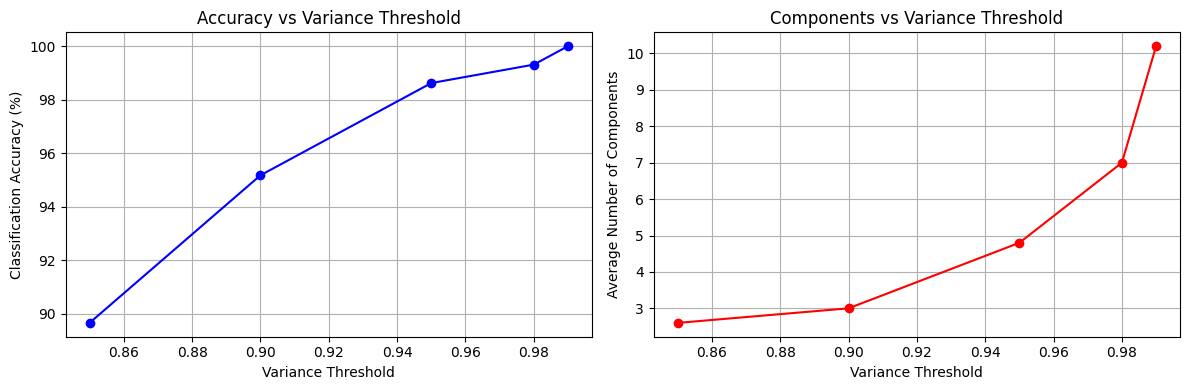

In [27]:
# Experiment with different variance thresholds
print("=== Hyperparameter Tuning ===")
print("Testing different variance thresholds...")

variance_thresholds = [0.85, 0.90, 0.95, 0.98, 0.99]
results = []

for threshold in variance_thresholds:
    print(f"\\nTesting variance threshold: {threshold}")
    
    # Train classifier with this threshold
    classifier_test = EigenFaceClassifier(variance_threshold=threshold)
    classifier_test.train(train_vectors)
    
    # Test the classifier
    predictions_test, _ = classifier_test.predict(test_vectors)
    accuracy_test = np.mean(predictions_test == test_labels) * 100
    
    results.append({
        'threshold': threshold,
        'accuracy': accuracy_test,
        'avg_components': np.mean([model['n_components'] 
                                 for model in classifier_test.person_models.values()])
    })
    
    print(f"  Accuracy: {accuracy_test:.2f}%")
    print(f"  Avg components per person: {results[-1]['avg_components']:.1f}")

# Find best threshold
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\\n=== Best Parameters ===")
print(f"Best variance threshold: {best_result['threshold']}")
print(f"Best accuracy: {best_result['accuracy']:.2f}%")
print(f"Average components: {best_result['avg_components']:.1f}")

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
thresholds = [r['threshold'] for r in results]
accuracies = [r['accuracy'] for r in results]
plt.plot(thresholds, accuracies, 'bo-')
plt.xlabel('Variance Threshold')
plt.ylabel('Classification Accuracy (%)')
plt.title('Accuracy vs Variance Threshold')
plt.grid(True)

plt.subplot(1, 2, 2)
components = [r['avg_components'] for r in results]
plt.plot(thresholds, components, 'ro-')
plt.xlabel('Variance Threshold')
plt.ylabel('Average Number of Components')
plt.title('Components vs Variance Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()